### Дипломная работа Н.В.Чепурных, студент курса "Аналитик данных"
### Научный руководитель: Алексей Кузьмин
Тема: прогнозирование ежемесячного потребления электрической энергии физическими лицами в электросетевой компании.

Этапы работ:
- Этап 1. Загрузка и объединение данных
- Этап 2. Обработка данных
- Этап 3. Применение модели Линейной регрессии
- Этап 4. Анализ данных, выбросы
- Этап 5. Модель Случайного леса
- Этап 6. Применение наиболее точных данных по потреблению с приборов учета, информацию по которым собирается удаленно системой опроса. Построение моделей Линейной регрессии и Случайного леса
- Этап 7. Добавление 2-х новых признаков - потребление за 2019 год и последний месяц. Построение моделей Линейной регрессии и Случайного леса
- Этап 8. Применение модели Градиентного бустинга
- Этап 9. Добавление нового признака - потери электроэнергии за 2019 год, применение 3-х моделей, сравнение результатов
- Этап 10. Гиперпараметрическая оптимизация модели градиентного бустинга. Случайный поиск с перекрёстной проверкой
- Этап 11. Заключение

Загрузка библиотек:

In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

### Этап 1. Загрузка и объединение данных

1.1. Загрузка данных по полезному отпуску электроэнергии за период 2019-2020

In [2]:
%%time
dirName = './Data/Supply/'
supply_all = []
for name in os.listdir(dirName):
    fullname = os.path.join(dirName, name) # получаем полное имя
    if os.path.isfile(fullname):
        df = pd.read_excel(fullname)
        print ("Обработан файл:", fullname, " - загружено строк:", len(df))
        supply_all.append(df)
supply_temp = pd.concat(supply_all,axis=0,ignore_index=True)
print("Всего строк загружено: ", len(supply_temp))

Обработан файл: ./Data/Supply/2019 01.xlsx  - загружено строк: 361365
Обработан файл: ./Data/Supply/2019 02.xlsx  - загружено строк: 361384
Обработан файл: ./Data/Supply/2019 03.xlsx  - загружено строк: 361888
Обработан файл: ./Data/Supply/2019 04.xlsx  - загружено строк: 368771
Обработан файл: ./Data/Supply/2019 05.xlsx  - загружено строк: 373635
Обработан файл: ./Data/Supply/2019 06.xlsx  - загружено строк: 377873
Обработан файл: ./Data/Supply/2019 07.xlsx  - загружено строк: 377808
Обработан файл: ./Data/Supply/2019 08.xlsx  - загружено строк: 376587
Обработан файл: ./Data/Supply/2019 09.xlsx  - загружено строк: 374118
Обработан файл: ./Data/Supply/2019 10.xlsx  - загружено строк: 379904
Обработан файл: ./Data/Supply/2019 11.xlsx  - загружено строк: 375713
Обработан файл: ./Data/Supply/2019 12.xlsx  - загружено строк: 370133
Обработан файл: ./Data/Supply/2020 01.xlsx  - загружено строк: 360223
Обработан файл: ./Data/Supply/2020 02.xlsx  - загружено строк: 362710
Обработан файл: ./Da

In [3]:
supply_temp

,Method,Consumer,Building,Supply,Status,Period
0,ЛС-СДСД,66700000233,дача,0.0,неоспар.,01-2019
1,ЛС-СДСД,66700000410,дача,0.0,неоспар.,01-2019
2,ЛС-СДСД,66700000431,част. ж/дом,2.0,неоспар.,01-2019
3,ЛС-СДСД,66700000557,дача,2.0,неоспар.,01-2019
4,ЛС-СДСД,66700000575,дача,21.0,неоспар.,01-2019
...,...,...,...,...,...,...
5545974,ЛС-ЭНОРМ,69198110501,дача,0.0,неоспар.,03-2020
5545975,ЛС-ЭНОРМ,69198110514,дача,145.0,неоспар.,03-2020
5545976,ЛС-ЭНОРМ,69198110624,дача,145.0,неоспар.,03-2020
5545977,ЛС-ЭНОРМ,69198110718,дача,145.0,неоспар.,03-2020


1.2. Загрузка данных по погоде с 2018 года  по апрель 2020 года.

Сайт с архивом погоды: https://rp5.ru/%D0%90%D1%80%D1%85%D0%B8%D0%B2_%D0%BF%D0%BE%D0%B3%D0%BE%D0%B4%D1%8B_%D0%B2_%D0%9F%D0%B5%D1%80%D0%BC%D0%B8,_%D0%91%D0%BE%D0%BB%D1%8C%D1%88%D0%BE%D0%BC_%D0%A1%D0%B0%D0%B2%D0%B8%D0%BD%D0%BE_(%D0%B0%D1%8D%D1%80%D0%BE%D0%BF%D0%BE%D1%80%D1%82),_METAR

In [4]:
%%time
dirName = './Data/'
name = 'perm_weather_2018.csv'
fullname = os.path.join(dirName, name) # получаем полное имя
if os.path.isfile(fullname):
    weather_temp = pd.read_csv(fullname, sep = ';', encoding = "ISO-8859-1", engine='python')
    print ("Обработан файл:", fullname, " - загружено строк:", len(weather_temp))
else: 
    print ("Ошибка загрузки:", fullname)

Обработан файл: ./Data/perm_weather_2018.csv  - загружено строк: 39987
Wall time: 424 ms


In [5]:
weather_temp.head()

,local time Perm,T
0,28.04.2020 23:30,8.0
1,28.04.2020 23:00,8.0
2,28.04.2020 22:30,8.0
3,28.04.2020 22:00,8.0
4,28.04.2020 21:30,8.0


Преобразовываем строковый параметр к виду mm-yyyy и группируем по месяцам. Получаем среднемесячную температуру.

In [6]:
weather_temp['local time Perm'] = weather_temp['local time Perm'].str.extract('(\d{2}.\d{2}.\d{4})')
weather_temp['local time Perm'] = weather_temp['local time Perm'].str.replace(r'^...','').str.replace('.','-')

In [7]:
weather = weather_temp.groupby('local time Perm').agg({'T': 'mean'}).reset_index()
weather.head()

,local time Perm,T
0,01-2018,-11.211210
1,01-2019,-11.163823
2,01-2020,-6.307012
3,02-2018,-12.592873
4,02-2019,-9.677711


Добавляем среднемесячную температуру в датасет supply

In [8]:
supply = supply_temp.merge(weather, how = 'left', left_on='Period', right_on='local time Perm')
supply.drop(['local time Perm'],axis=1, inplace=True)
supply.head()

,Method,Consumer,Building,Supply,Status,Period,T
0,ЛС-СДСД,66700000233,дача,0.0,неоспар.,01-2019,-11.163823
1,ЛС-СДСД,66700000410,дача,0.0,неоспар.,01-2019,-11.163823
2,ЛС-СДСД,66700000431,част. ж/дом,2.0,неоспар.,01-2019,-11.163823
3,ЛС-СДСД,66700000557,дача,2.0,неоспар.,01-2019,-11.163823
4,ЛС-СДСД,66700000575,дача,21.0,неоспар.,01-2019,-11.163823


1.3. Загружаем данные по потребителям: количество комнат, количество проживающих, потери электроэнергии в регионе проживания потребителя в 2019 году (усредненные по всем жителям региона).

In [9]:
%%time
dirName = './Data/'
name = 'RoomsPeoplesLoss.xlsx'
fullname = os.path.join(dirName, name) # получаем полное имя
if os.path.isfile(fullname):
    RoomsPeoples = pd.read_excel(fullname)
    print ("Обработан файл:", fullname, " - загружено строк:", len(RoomsPeoples))
else: 
    print ("Ошибка загрузки:", fullname)

Обработан файл: ./Data/RoomsPeoplesLoss.xlsx  - загружено строк: 397671
Wall time: 28.6 s


In [10]:
RoomsPeoples.head()

,Consumer,Rooms,Peoples,Loss2019
0,62800121655,1.0,1.0,0.08804
1,62840754350,1.0,1.0,0.08804
2,00003,1.0,1.0,0.08804
3,61007104593,1.0,1.0,0.08804
4,61009048247,NaN,1.0,0.08804


Добавляем информацию в датасет supply

In [11]:
supply = supply.merge(RoomsPeoples, how = 'left', left_on='Consumer', right_on='Consumer')
supply.head()

,Method,Consumer,Building,Supply,Status,Period,T,Rooms,Peoples,Loss2019
0,ЛС-СДСД,66700000233,дача,0.0,неоспар.,01-2019,-11.163823,1.0,1.0,0.027669
1,ЛС-СДСД,66700000410,дача,0.0,неоспар.,01-2019,-11.163823,1.0,1.0,0.027669
2,ЛС-СДСД,66700000431,част. ж/дом,2.0,неоспар.,01-2019,-11.163823,1.0,1.0,0.027669
3,ЛС-СДСД,66700000557,дача,2.0,неоспар.,01-2019,-11.163823,1.0,1.0,0.027669
4,ЛС-СДСД,66700000575,дача,21.0,неоспар.,01-2019,-11.163823,1.0,1.0,0.027669


1.4. Загружаем данные по категориям потребителей из каталога /Data/Group/

In [12]:
%%time
dirName = './Data/Group/'
group_all = []
for name in os.listdir(dirName):
    fullname = os.path.join(dirName, name) # получаем полное имя
    if os.path.isfile(fullname):
        dfg = pd.read_excel(fullname)
        print ("Обработан файл:", fullname, " - загружено строк:", len(dfg))
        group_all.append(dfg)
group_temp = pd.concat(group_all,axis=0,ignore_index=True)
print("Всего строк загружено: ", len(group_temp))

Обработан файл: ./Data/Group/bes_filtered.xlsx  - загружено строк: 47614
Обработан файл: ./Data/Group/ces_filtered.xlsx  - загружено строк: 103516
Обработан файл: ./Data/Group/chaes_filtered.xlsx  - загружено строк: 83823
Обработан файл: ./Data/Group/chues_filtered.xlsx  - загружено строк: 28754
Обработан файл: ./Data/Group/kues_filtered.xlsx  - загружено строк: 80955
Обработан файл: ./Data/Group/oches_filtered.xlsx  - загружено строк: 63447
Обработан файл: ./Data/Group/pges_filtered.xlsx  - загружено строк: 101690
Обработан файл: ./Data/Group/ses_filtered.xlsx  - загружено строк: 42740
Всего строк загружено:  552539
Wall time: 21.8 s


In [13]:
group_temp.head()

,Consumer,Group
0,66700334153,Население сельское
1,66400019149,Население городское
2,66400042245,Население сельское
3,66400042147,Население сельское
4,66400042147,Население сельское


Удаляем дубликаты

In [14]:
group_temp.drop_duplicates(keep='first', inplace=True)
print(len(group_temp))

346300


Добавляем информацию в датасет supply

In [15]:
#supply.drop('Group', axis=1, inplace=True)
supply.head()

,Method,Consumer,Building,Supply,Status,Period,T,Rooms,Peoples,Loss2019
0,ЛС-СДСД,66700000233,дача,0.0,неоспар.,01-2019,-11.163823,1.0,1.0,0.027669
1,ЛС-СДСД,66700000410,дача,0.0,неоспар.,01-2019,-11.163823,1.0,1.0,0.027669
2,ЛС-СДСД,66700000431,част. ж/дом,2.0,неоспар.,01-2019,-11.163823,1.0,1.0,0.027669
3,ЛС-СДСД,66700000557,дача,2.0,неоспар.,01-2019,-11.163823,1.0,1.0,0.027669
4,ЛС-СДСД,66700000575,дача,21.0,неоспар.,01-2019,-11.163823,1.0,1.0,0.027669


In [16]:
group_temp['Consumer'] = group_temp['Consumer'].astype(str)
supply = supply.merge(group_temp, how = 'left', left_on='Consumer', right_on='Consumer')
supply.head()

,Method,Consumer,Building,Supply,Status,Period,T,Rooms,Peoples,Loss2019,Group
0,ЛС-СДСД,66700000233,дача,0.0,неоспар.,01-2019,-11.163823,1.0,1.0,0.027669,Население сельское
1,ЛС-СДСД,66700000410,дача,0.0,неоспар.,01-2019,-11.163823,1.0,1.0,0.027669,Население сельское
2,ЛС-СДСД,66700000431,част. ж/дом,2.0,неоспар.,01-2019,-11.163823,1.0,1.0,0.027669,Население сельское
3,ЛС-СДСД,66700000557,дача,2.0,неоспар.,01-2019,-11.163823,1.0,1.0,0.027669,Население сельское
4,ЛС-СДСД,66700000575,дача,21.0,неоспар.,01-2019,-11.163823,1.0,1.0,0.027669,Население сельское


### Этап 2. Обработка данных

2.1. Удаляем дубликаты

In [17]:
supply.drop_duplicates(keep='first', inplace=True)
print(len(supply))

5540437


2.2. Удаляем все строки со статусом Status = "оспар.", потом удаляем сам столбец за ненадобностью (он используется при расчетах полезного отпуска)

In [18]:
supply = supply.loc[supply['Status']!='оспар.']
print(len(supply))

5492797


In [19]:
supply.drop('Status', axis=1, inplace=True)
supply.head()

,Method,Consumer,Building,Supply,Period,T,Rooms,Peoples,Loss2019,Group
0,ЛС-СДСД,66700000233,дача,0.0,01-2019,-11.163823,1.0,1.0,0.027669,Население сельское
1,ЛС-СДСД,66700000410,дача,0.0,01-2019,-11.163823,1.0,1.0,0.027669,Население сельское
2,ЛС-СДСД,66700000431,част. ж/дом,2.0,01-2019,-11.163823,1.0,1.0,0.027669,Население сельское
3,ЛС-СДСД,66700000557,дача,2.0,01-2019,-11.163823,1.0,1.0,0.027669,Население сельское
4,ЛС-СДСД,66700000575,дача,21.0,01-2019,-11.163823,1.0,1.0,0.027669,Население сельское


Делаем копию основного датасета со столбцом Period, это нам понадобится на этапе 8.

In [20]:
ds_supply = supply.copy()

2.3. Удаляем столбец "Period", т.к. он использовался только для добавления среднемесячной температуры

In [21]:
supply.drop('Period', axis=1, inplace=True)
supply.head()

,Method,Consumer,Building,Supply,T,Rooms,Peoples,Loss2019,Group
0,ЛС-СДСД,66700000233,дача,0.0,-11.163823,1.0,1.0,0.027669,Население сельское
1,ЛС-СДСД,66700000410,дача,0.0,-11.163823,1.0,1.0,0.027669,Население сельское
2,ЛС-СДСД,66700000431,част. ж/дом,2.0,-11.163823,1.0,1.0,0.027669,Население сельское
3,ЛС-СДСД,66700000557,дача,2.0,-11.163823,1.0,1.0,0.027669,Население сельское
4,ЛС-СДСД,66700000575,дача,21.0,-11.163823,1.0,1.0,0.027669,Население сельское


Удаляем столбец "Loss2019", т.к. он будет использоваться на этапе 10 для улучшения прогноза

In [22]:
supply.drop('Loss2019', axis=1, inplace=True)
supply.head()

,Method,Consumer,Building,Supply,T,Rooms,Peoples,Group
0,ЛС-СДСД,66700000233,дача,0.0,-11.163823,1.0,1.0,Население сельское
1,ЛС-СДСД,66700000410,дача,0.0,-11.163823,1.0,1.0,Население сельское
2,ЛС-СДСД,66700000431,част. ж/дом,2.0,-11.163823,1.0,1.0,Население сельское
3,ЛС-СДСД,66700000557,дача,2.0,-11.163823,1.0,1.0,Население сельское
4,ЛС-СДСД,66700000575,дача,21.0,-11.163823,1.0,1.0,Население сельское


2.4. Из столбца "Building" извлекаем данные о том, постоянно ли проживают по данному адресу (не дача) или нет. Добавляем столбец "Permanent_Residence", которое принимает значение 1 при постоянном проживании, и 0 в обратном случае.

In [23]:
supply['Building'].unique()

array(['дача', 'част. ж/дом', 'кварт.', 'баня', 'стр.площ.', 'гараж',
       'кв. малокв.', 'хоз.постр.', 'прочие хоз.', 'мнкв.дом', 'ТП',
       'Не опр.', 'прочие пром.', 'разрушенный', 'нежилой',
       'общест. объект', 'нежилое в мн.кв.', 'нежилая кварт.',
       'водокачка', 'религ. объект', 'общежитие', 'эл.отопл.', 'пилорама',
       'проч. объекты юр.лиц', 'мастерская', 'яма', 'сад',
       'мнкв.авар.дом', 'мнкв.ветх.дом'], dtype=object)

In [24]:
def Permanent_Residence(b):
    perm_list = ['кварт.','част. ж/дом','кв. малокв.','мнкв.дом','общежитие', 'эл.отопл.']
    if b in perm_list:
        return 1
    else:
        return 0

In [25]:
supply['Permanent_Residence'] = supply['Building'].apply(Permanent_Residence)

Удаляем столбец "Building"

In [26]:
supply.drop('Building', axis=1, inplace=True)
supply.head()

,Method,Consumer,Supply,T,Rooms,Peoples,Group,Permanent_Residence
0,ЛС-СДСД,66700000233,0.0,-11.163823,1.0,1.0,Население сельское,0
1,ЛС-СДСД,66700000410,0.0,-11.163823,1.0,1.0,Население сельское,0
2,ЛС-СДСД,66700000431,2.0,-11.163823,1.0,1.0,Население сельское,1
3,ЛС-СДСД,66700000557,2.0,-11.163823,1.0,1.0,Население сельское,0
4,ЛС-СДСД,66700000575,21.0,-11.163823,1.0,1.0,Население сельское,0


2.5. Из столбца "Group" извлекаем данные о том, потребитель сельский или городской. 
Добавляем столбец "City", которое принимает значение 1 при городском расположении, и 0 в обратном случае.

In [27]:
supply['Group'].unique()

array(['Население сельское', 'Население городское', nan,
       'Приравненные к населению (село)',
       'Приравненные к населению (город)', 'Не определено',
       'Непромышленные потребители', 'Промышленные потребители'],
      dtype=object)

In [28]:
def City_Residence(b):
    perm_list = ['Население городское','Приравненные к населению (город)','Непромышленные потребители', 'Промышленные потребители']
    if b in perm_list:
        return 1
    else:
        return 0

In [29]:
supply['City'] = supply['Group'].apply(City_Residence)

Удаляем столбец "Group"

In [30]:
supply.drop('Group', axis=1, inplace=True)
supply.head()

,Method,Consumer,Supply,T,Rooms,Peoples,Permanent_Residence,City
0,ЛС-СДСД,66700000233,0.0,-11.163823,1.0,1.0,0,0
1,ЛС-СДСД,66700000410,0.0,-11.163823,1.0,1.0,0,0
2,ЛС-СДСД,66700000431,2.0,-11.163823,1.0,1.0,1,0
3,ЛС-СДСД,66700000557,2.0,-11.163823,1.0,1.0,0,0
4,ЛС-СДСД,66700000575,21.0,-11.163823,1.0,1.0,0,0


2.6. Из столбца "Consumer" удаляем всех потребителей, у которых договор не состоит из одних цифр. 
Эти договоры не имеют отношение к населению.

In [31]:
supply[supply['Consumer'].str.contains('\D+',flags=re.IGNORECASE, regex=True)]

,Method,Consumer,Supply,T,Rooms,Peoples,Permanent_Residence,City
2265,ЛС-КПП,ОДУ У Беляева 26,0.0,-11.163823,NaN,NaN,1,0
9654,ЛС-КПБ,МКД ЮГ без УК,0.0,-11.163823,2.0,6.0,0,1
12484,ЛС-НОРМ,МКД СЕВЕР (не определено),0.0,-11.163823,8.0,64.0,0,1
12491,ЛС-НОРМ,МКД СЕВЕР (непосредственное),0.0,-11.163823,2.0,2.0,0,1
12496,ЛС-НОРМ,МКД ЮГ без УК,0.0,-11.163823,2.0,6.0,0,1
...,...,...,...,...,...,...,...,...
5490340,ЛС-ЭКП,65300004805,1250.0,0.552076,8.0,4.0,1,0
5505648,ЛС-СДСД,3+ОДПУ,1951.0,0.552076,16.0,16.0,1,1
5505649,ЛС-СДСД,3836 ОДПУ,293.0,0.552076,0.0,3.0,1,1
5538945,ЛС-НОРМ,для з/д,145.0,0.552076,12.0,17.0,1,1


In [32]:
supply = supply[~supply['Consumer'].str.contains('\D+',flags=re.IGNORECASE, regex=True)]

2.7. Проверяем на пустые значения и заполняем данными

In [33]:
supply.isnull().sum()

Method                      0
Consumer                    0
Supply                      0
T                           0
Rooms                  196913
Peoples                189959
Permanent_Residence         0
City                        0
dtype: int64

In [34]:
supply.describe()

,Supply,T,Rooms,Peoples,Permanent_Residence,City
count,5.488514e+06,5.488514e+06,5.291601e+06,5.298555e+06,5.488514e+06,5.488514e+06
mean,2.385357e+02,2.329012e+00,1.575308e+00,2.123745e+00,8.560282e-01,2.752709e-01
std,8.715885e+02,9.297460e+00,1.170219e+00,1.659896e+00,3.510611e-01,4.466507e-01
min,-4.572060e+05,-1.116382e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.300000e+01,-6.255830e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,1.420000e+02,5.520762e-01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
75%,2.500000e+02,1.340122e+01,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00
max,3.280420e+05,1.713523e+01,5.100000e+01,7.700000e+01,1.000000e+00,1.000000e+00


Для поля "Rooms" ставим среднее округленное значение 2.0, для поля "Peoples" значение 2.0

In [35]:
supply.fillna(value={'Rooms': 2, 'Peoples': 2}, inplace=True)
supply.head()

,Method,Consumer,Supply,T,Rooms,Peoples,Permanent_Residence,City
0,ЛС-СДСД,66700000233,0.0,-11.163823,1.0,1.0,0,0
1,ЛС-СДСД,66700000410,0.0,-11.163823,1.0,1.0,0,0
2,ЛС-СДСД,66700000431,2.0,-11.163823,1.0,1.0,1,0
3,ЛС-СДСД,66700000557,2.0,-11.163823,1.0,1.0,0,0
4,ЛС-СДСД,66700000575,21.0,-11.163823,1.0,1.0,0,0


In [36]:
supply.isnull().sum()

Method                 0
Consumer               0
Supply                 0
T                      0
Rooms                  0
Peoples                0
Permanent_Residence    0
City                   0
dtype: int64

Теперь создаем копию датасета под именем ds_work, с ним работаем дальше. А в датасете supply остается полная копия данных, к которым можно вернуться, если надо будет изменять модель и добавлять новые признаки.

In [37]:
ds_work = supply.copy()
ds_work.head()

,Method,Consumer,Supply,T,Rooms,Peoples,Permanent_Residence,City
0,ЛС-СДСД,66700000233,0.0,-11.163823,1.0,1.0,0,0
1,ЛС-СДСД,66700000410,0.0,-11.163823,1.0,1.0,0,0
2,ЛС-СДСД,66700000431,2.0,-11.163823,1.0,1.0,1,0
3,ЛС-СДСД,66700000557,2.0,-11.163823,1.0,1.0,0,0
4,ЛС-СДСД,66700000575,21.0,-11.163823,1.0,1.0,0,0


Удаляем из датасета ds_work столбец Method, т.к. этот столбец будет нужен для более тонкой настройки модели. Если прямой подход "в лоб" не сработает.

In [38]:
ds_work.drop('Method', axis=1, inplace=True)
ds_work.head()

,Consumer,Supply,T,Rooms,Peoples,Permanent_Residence,City
0,66700000233,0.0,-11.163823,1.0,1.0,0,0
1,66700000410,0.0,-11.163823,1.0,1.0,0,0
2,66700000431,2.0,-11.163823,1.0,1.0,1,0
3,66700000557,2.0,-11.163823,1.0,1.0,0,0
4,66700000575,21.0,-11.163823,1.0,1.0,0,0


In [39]:
ds_work.drop('Consumer', axis=1, inplace=True)
ds_work.head()

,Supply,T,Rooms,Peoples,Permanent_Residence,City
0,0.0,-11.163823,1.0,1.0,0,0
1,0.0,-11.163823,1.0,1.0,0,0
2,2.0,-11.163823,1.0,1.0,1,0
3,2.0,-11.163823,1.0,1.0,0,0
4,21.0,-11.163823,1.0,1.0,0,0


In [40]:
ds_work.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5488514 entries, 0 to 5547178
Data columns (total 6 columns):
Supply                 float64
T                      float64
Rooms                  float64
Peoples                float64
Permanent_Residence    int64
City                   int64
dtypes: float64(4), int64(2)
memory usage: 293.1 MB


### Этап 3. Применение модели Линейной регрессии

In [41]:
X_train, X_test, y_train, y_test = train_test_split(ds_work[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City']], ds_work['Supply'], test_size=0.3)

In [42]:
model = LinearRegression()

In [43]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Оценим качество модели

In [44]:
r_train = model.score(X_train, y_train)
r_test = model.score(X_test, y_test)
print('Качество модели на тестовых данных:', r_test, '\nКачество модели на тренировочных данных:', r_train)

Качество модели на тестовых данных: 0.0036432807151408615 
Качество модели на тренировочных данных: 0.0038101453158912997


In [45]:
model_pred = model.predict(X_test)
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, model_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, model_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, model_pred)))
mape = np.mean(np.abs((y_test - model_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Model score:', model.score(X_test, y_test))
print('R2 score:', r2_score(y_test, model_pred))

Mean Absolute Error (MAE): 247.03978486537565
Mean Squared Error (MSE): 807800.8585669927
Root Mean Squared Error (RMSE): 898.7774243754639
Mean Absolute Percentage Error (MAPE): inf
Model score: 0.0036432807151408615
R2 score: 0.003643280715140862


In [71]:
sum_pred = sum(model_pred)
sum_fact = sum(y_test)
print('Прогноз потребления населением на тестовом наборе данных: ',round(sum_pred,0),'кВт*ч')
print('Фактическое потребления населением на тестовом наборе данных: ',round(sum_fact,0),'кВт*ч')
print('Разница между фактом и прогнозом, абсолют:',round(sum_fact - sum_pred,0),'кВт*ч', 
      ' процент:', round(100*np.abs((sum_fact - sum_pred))/sum_pred,4),'%')

Прогноз потребления населением на тестовом наборе данных:  393400936.0 кВт*ч
Фактическое потребления населением на тестовом наборе данных:  391583588.0 кВт*ч
Разница между фактом и прогнозом, абсолют: -1817348.0 кВт*ч  процент: 0.462 %


### Абсолютно неудовлетворительное качество модели

### Этап 4. Анализ данных, выбросы

In [72]:
ds_work.describe()

,Supply,T,Rooms,Peoples,Permanent_Residence,City
count,5.488514e+06,5.488514e+06,5.488514e+06,5.488514e+06,5.488514e+06,5.488514e+06
mean,2.385357e+02,2.329012e+00,1.590545e+00,2.119463e+00,8.560282e-01,2.752709e-01
std,8.715885e+02,9.297460e+00,1.151747e+00,1.631075e+00,3.510611e-01,4.466507e-01
min,-4.572060e+05,-1.116382e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.300000e+01,-6.255830e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,1.420000e+02,5.520762e-01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
75%,2.500000e+02,1.340122e+01,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00
max,3.280420e+05,1.713523e+01,5.100000e+01,7.700000e+01,1.000000e+00,1.000000e+00


4.1. Устранение выбросов

Для устранения выбросов интересны:
- признак Supply(полезный отпуск электроэнергии): следует убрать отрицательные значения (они говорят о корректировке ранее неправильно введенных данных), нулевые значения (в этот период или показания не снимались у потребителя, или расчет полезного отпуска был проведен по нулевым данным), значения свыше 5 тыс.(это может говорить либо о сильном электропотреблении зимой у коттеджей, либо о расчете полезного отпуска не за 1 месяц, а, например, за год)
- признак Peoples(люди): максимум в 77 человек говорит о том, что возможно попало немного данных не по физическим лицам, а по многоквартирным домам, их надо убрать;
- признак R(комнаты): максимум в 51 комнату говорит о том, что возможно попало немного данных не по физическим лицам, а по многоквартирным домам, их надо убрать;
- признаки T(температура), , Permanent_Residence(постоянное проживание) и City(город) не имеют выбросов.

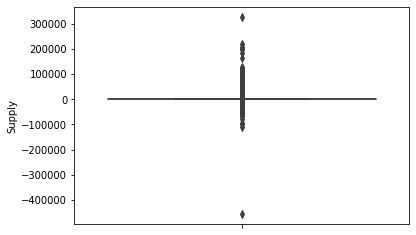

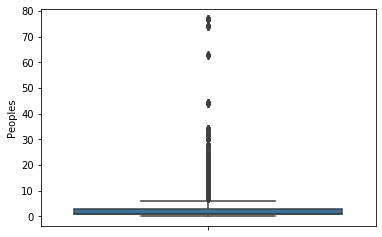

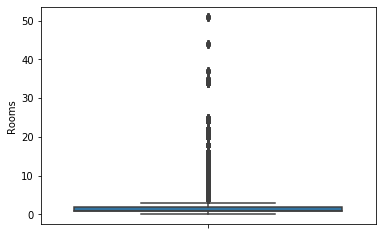

In [73]:
sns.boxplot(y="Supply", data=ds_work)
plt.show()
sns.boxplot(y="Peoples", data=ds_work)
plt.show()
sns.boxplot(y="Rooms", data=ds_work)
plt.show()

In [74]:
print(len(ds_work[ds_work['Supply'] <1]), len(ds_work[ds_work['Supply'] == 0]), len(ds_work[ds_work['Supply'] > 4000]))

774305 542570 20757


In [75]:
ds_work = ds_work[ds_work['Supply'] >=1]
ds_work = ds_work[ds_work['Supply'] <4000]

In [76]:
ds_work = ds_work[ds_work['Peoples'] <10]
ds_work = ds_work[ds_work['Rooms'] <10]

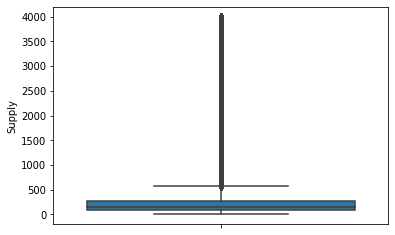

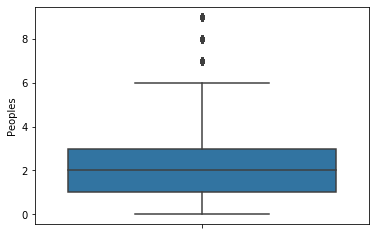

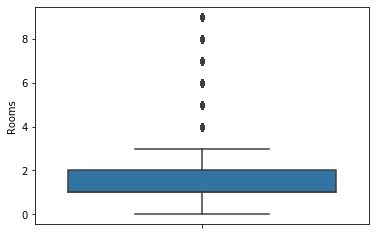

In [77]:
#plt.figure(figsize=(6,6))
sns.boxplot(y="Supply", data=ds_work)
plt.show()
sns.boxplot(y="Peoples", data=ds_work)
plt.show()
sns.boxplot(y="Rooms", data=ds_work)
plt.show()

In [78]:
ds_work.describe()

,Supply,T,Rooms,Peoples,Permanent_Residence,City
count,4.665778e+06,4.665778e+06,4.665778e+06,4.665778e+06,4.665778e+06,4.665778e+06
mean,2.632127e+02,2.471041e+00,1.602664e+00,2.134501e+00,8.826129e-01,2.851004e-01
std,3.874355e+02,9.327716e+00,1.075234e+00,1.485177e+00,3.218810e-01,4.514623e-01
min,1.000000e+00,-1.116382e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.600000e+01,-6.255830e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,1.530000e+02,5.520762e-01,1.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00
75%,2.780000e+02,1.340122e+01,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00
max,3.999000e+03,1.713523e+01,9.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00


4.2. Матрица корреляций

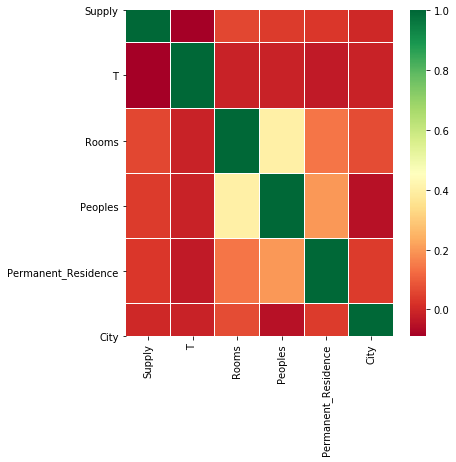

In [79]:
f, ax = plt.subplots(figsize=(6, 6))
corr = np.round_(ds_work.corr(), decimals=2)
sns.heatmap(corr,annot=False,cmap='RdYlGn',linewidths=0.2)

Корреляция между признаками выражена слабо, только комнаты и люди коррелируют, но это было ожидаемо - чем больше людей живет, тем больше комнат требуется.

4.3. Визуализация взаимосвязей между признаками

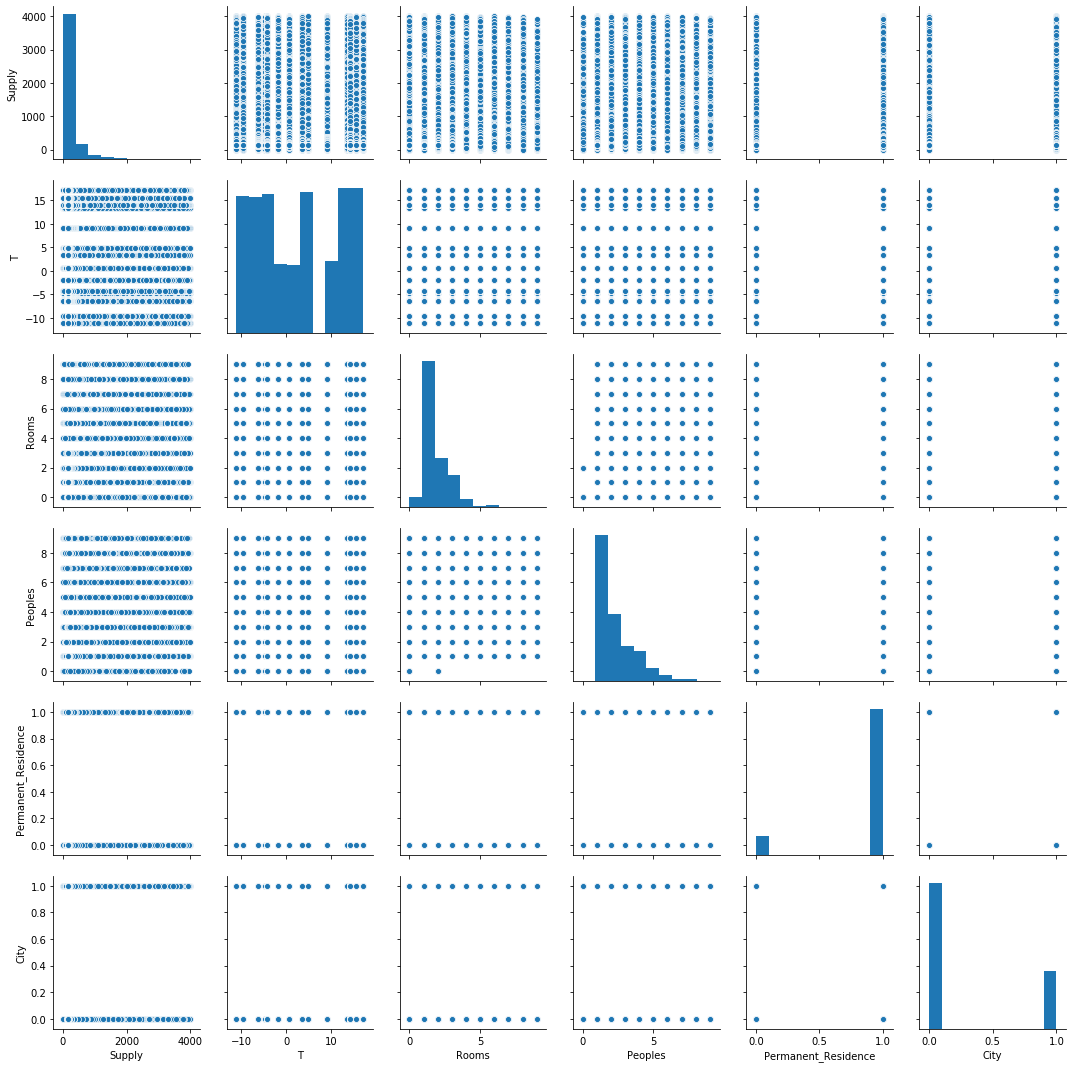

In [68]:
sns.pairplot(ds_work)
plt.show()

Этап 5. Модель "Random forest"

Теперь на очищенных данных применяем снова модель линейной регрессии и модель случайного леса.

5.1. Линейная регрессия

In [80]:
X_train, X_test, y_train, y_test = train_test_split(ds_work[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City']], ds_work['Supply'], test_size=0.3)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [81]:
r_train = model.score(X_train, y_train)
r_test = model.score(X_test, y_test)
print('Качество модели на тестовых данных:', r_test, '\nКачество модели на тренировочных данных:', r_train)

Качество модели на тестовых данных: 0.012475449943785466 
Качество модели на тренировочных данных: 0.012612920923796178


In [82]:
model_pred = model.predict(X_test)
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, model_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, model_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, model_pred)))
mape = np.mean(np.abs((y_test - model_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Model score:', model.score(X_test, y_test))
print('R2 score:', r2_score(y_test, model_pred))

Mean Absolute Error (MAE): 206.80784628653885
Mean Squared Error (MSE): 148031.95489359056
Root Mean Squared Error (RMSE): 384.7492103872217
Mean Absolute Percentage Error (MAPE): 712.96
Model score: 0.012475449943785466
R2 score: 0.012475449943785466


In [83]:
sum_pred = sum(model_pred)
sum_fact = sum(y_test)
print('Прогноз потребления населением на тестовом наборе данных: ',round(sum_pred,0),'кВт*ч')
print('Фактическое потребления населением на тестовом наборе данных: ',round(sum_fact,0),'кВт*ч')
print('Разница между фактом и прогнозом, абсолют:',round(sum_fact - sum_pred,0),'кВт*ч', 
      ' процент:', round(100*np.abs((sum_fact - sum_pred))/sum_pred,4),'%')

Прогноз потребления населением на тестовом наборе данных:  368270926.0 кВт*ч
Фактическое потребления населением на тестовом наборе данных:  368749707.0 кВт*ч
Разница между фактом и прогнозом, абсолют: 478781.0 кВт*ч  процент: 0.13 %


Качество модели на очищенных данных увеличилось в 3 раза, но все-равно остается на неудовлетворительном уровне.

5.2. Случайный лес

In [84]:
X_train, X_test, y_train, y_test = train_test_split(ds_work[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City']], ds_work['Supply'], test_size=0.3)
model_rf=RandomForestRegressor(n_estimators=100, max_features='auto', n_jobs=4, random_state=1)
model_rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=4, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [85]:
model_pred = model_rf.predict(X_test)
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, model_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, model_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, model_pred)))
mape = np.mean(np.abs((y_test - model_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Model score:', model_rf.score(X_test, y_test))
print('R2 score:', r2_score(y_test, model_pred))

Mean Absolute Error (MAE): 205.04547266568156
Mean Squared Error (MSE): 146282.55469410747
Root Mean Squared Error (RMSE): 382.4690244897062
Mean Absolute Percentage Error (MAPE): 725.98
Model score: 0.024301050354106565
R2 score: 0.024301050354106568


In [86]:
sum_pred = sum(model_pred)
sum_fact = sum(y_test)
print('Прогноз потребления населением на тестовом наборе данных: ',round(sum_pred,0),'кВт*ч')
print('Фактическое потребления населением на тестовом наборе данных: ',round(sum_fact,0),'кВт*ч')
print('Разница между фактом и прогнозом, абсолют:',round(sum_fact - sum_pred,0),'кВт*ч', 
      ' процент:', round(100*np.abs((sum_fact - sum_pred))/sum_pred,4),'%')

Прогноз потребления населением на тестовом наборе данных:  368608382.0 кВт*ч
Фактическое потребления населением на тестовом наборе данных:  368174525.0 кВт*ч
Разница между фактом и прогнозом, абсолют: -433857.0 кВт*ч  процент: 0.1177 %


Наиболее важные признаки:

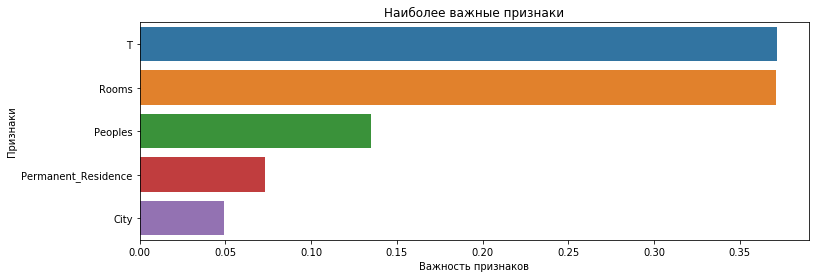

In [87]:
headers = list(X_train.columns.values)
feature_imp = pd.Series(model_rf.feature_importances_,index=headers).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title("Наиболее важные признаки")
plt.show()

### Этап 6. Применение наиболее точных данных по потреблению с приборов учета, информацию по которым собирается удаленно системой опроса

Создаем вторую копию датасета supply под именем ds_sdsd, с ним работаем дальше. 
В этот датасет помещаем наиболее точные данные с приборов учета.

In [88]:
ds_sdsd = supply.copy()
ds_sdsd = ds_sdsd[ds_sdsd['Method']=='ЛС-СДСД']

In [89]:
ds_sdsd.drop('Method', axis=1, inplace=True)
ds_sdsd.drop('Consumer', axis=1, inplace=True)
ds_sdsd.head()

,Supply,T,Rooms,Peoples,Permanent_Residence,City
0,0.0,-11.163823,1.0,1.0,0,0
1,0.0,-11.163823,1.0,1.0,0,0
2,2.0,-11.163823,1.0,1.0,1,0
3,2.0,-11.163823,1.0,1.0,0,0
4,21.0,-11.163823,1.0,1.0,0,0


Устраняем выбросы

In [90]:
ds_sdsd = ds_sdsd[ds_sdsd['Supply'] >=1]
ds_sdsd = ds_sdsd[ds_sdsd['Supply'] <4000]
ds_sdsd = ds_sdsd[ds_sdsd['Peoples'] <10]
ds_sdsd = ds_sdsd[ds_sdsd['Rooms'] <10]

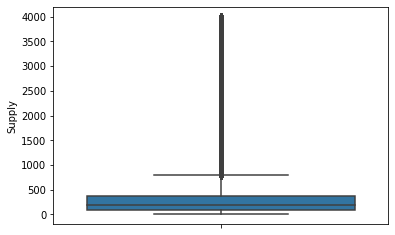

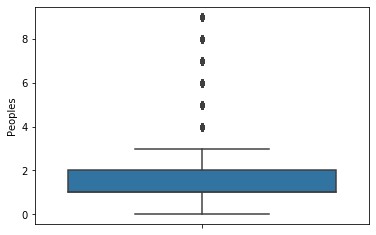

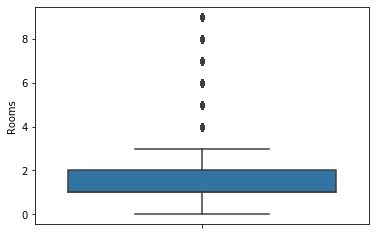

In [91]:
sns.boxplot(y="Supply", data=ds_sdsd)
plt.show()
sns.boxplot(y="Peoples", data=ds_sdsd)
plt.show()
sns.boxplot(y="Rooms", data=ds_sdsd)
plt.show()

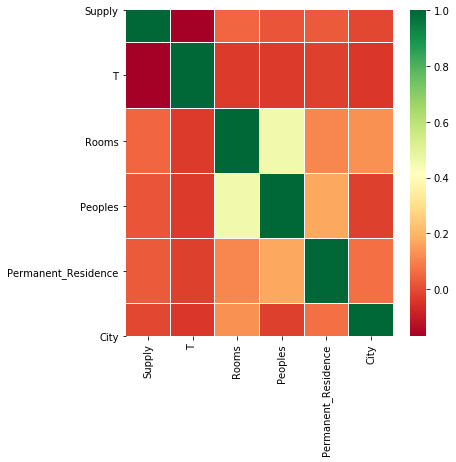

In [92]:
f, ax = plt.subplots(figsize=(6, 6))
corr = np.round_(ds_sdsd.corr(), decimals=2)
sns.heatmap(corr,annot=False,cmap='RdYlGn',linewidths=0.2)

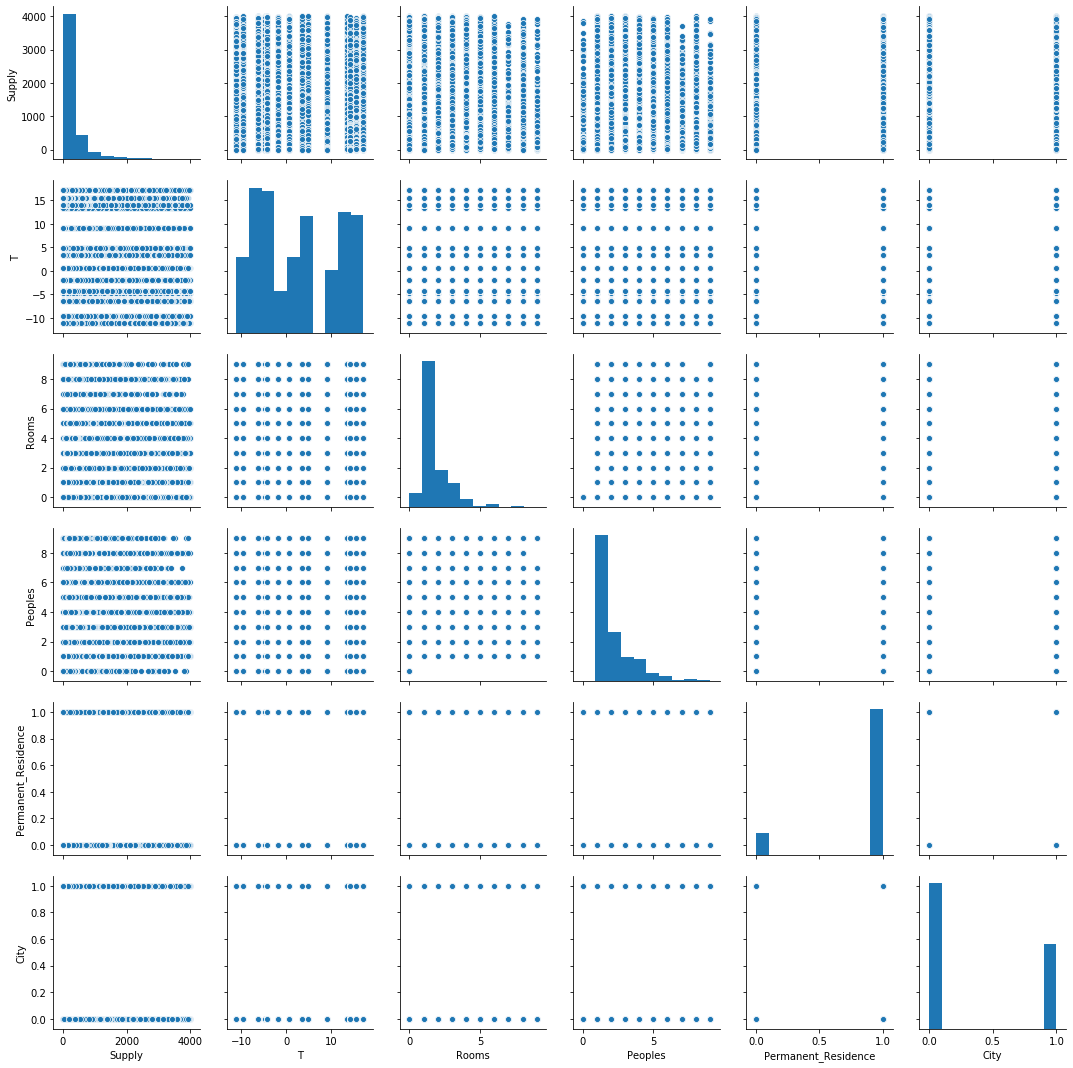

In [81]:
sns.pairplot(ds_sdsd)
plt.show()

Линейная регрессия

In [93]:
X_train, X_test, y_train, y_test = train_test_split(ds_sdsd[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City']], ds_sdsd['Supply'], test_size=0.3)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [94]:
r_train = model.score(X_train, y_train)
r_test = model.score(X_test, y_test)
print('Качество модели на тестовых данных:', r_test, '\nКачество модели на тренировочных данных:', r_train)
model_pred = model.predict(X_test)
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, model_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, model_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, model_pred)))
mape = np.mean(np.abs((y_test - model_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Model score:', model.score(X_test, y_test))
print('R2 score:', r2_score(y_test, model_pred))

Качество модели на тестовых данных: 0.03347669395504316 
Качество модели на тренировочных данных: 0.033075150090858374
Mean Absolute Error (MAE): 290.43711154346585
Mean Squared Error (MSE): 234623.3064187383
Root Mean Squared Error (RMSE): 484.37930015509363
Mean Absolute Percentage Error (MAPE): 1607.89
Model score: 0.03347669395504316
R2 score: 0.03347669395504316


In [95]:
sum_pred = sum(model_pred)
sum_fact = sum(y_test)
print('Прогноз потребления населением на тестовом наборе данных: ',round(sum_pred,0),'кВт*ч')
print('Фактическое потребления населением на тестовом наборе данных: ',round(sum_fact,0),'кВт*ч')
print('Разница между фактом и прогнозом, абсолют:',round(sum_fact - sum_pred,0),'кВт*ч', 
      ' процент:', round(100*np.abs((sum_fact - sum_pred))/sum_pred,4),'%')

Прогноз потребления населением на тестовом наборе данных:  71275588.0 кВт*ч
Фактическое потребления населением на тестовом наборе данных:  71005532.0 кВт*ч
Разница между фактом и прогнозом, абсолют: -270056.0 кВт*ч  процент: 0.3789 %


Выводы: результаты от модели на полных данных отличаются: выросли с 0,012 до 0.033. 

Можно выдвинуть гипотезу, что дело в неподходящей модели.

Случайный лес

In [96]:
X_train, X_test, y_train, y_test = train_test_split(ds_sdsd[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City']], ds_sdsd['Supply'], test_size=0.3)
model_rf=RandomForestRegressor(n_estimators=100, max_features='auto', n_jobs=4, random_state=1)
model_rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=4, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [97]:
model_pred = model_rf.predict(X_test)
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, model_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, model_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, model_pred)))
mape = np.mean(np.abs((y_test - model_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Model score:', model_rf.score(X_test, y_test))
print('R2 score:', r2_score(y_test, model_pred))

Mean Absolute Error (MAE): 289.2390239636114
Mean Squared Error (MSE): 235582.6257404602
Root Mean Squared Error (RMSE): 485.36854630317794
Mean Absolute Percentage Error (MAPE): 1662.95
Model score: 0.04178688817803222
R2 score: 0.04178688817803222


In [98]:
sum_pred = sum(model_pred)
sum_fact = sum(y_test)
print('Прогноз потребления населением на тестовом наборе данных: ',round(sum_pred,0),'кВт*ч')
print('Фактическое потребления населением на тестовом наборе данных: ',round(sum_fact,0),'кВт*ч')
print('Разница между фактом и прогнозом, абсолют:',round(sum_fact - sum_pred,0),'кВт*ч', 
      ' процент:', round(100*np.abs((sum_fact - sum_pred))/sum_pred,4),'%')

Прогноз потребления населением на тестовом наборе данных:  71310542.0 кВт*ч
Фактическое потребления населением на тестовом наборе данных:  71231097.0 кВт*ч
Разница между фактом и прогнозом, абсолют: -79445.0 кВт*ч  процент: 0.1114 %


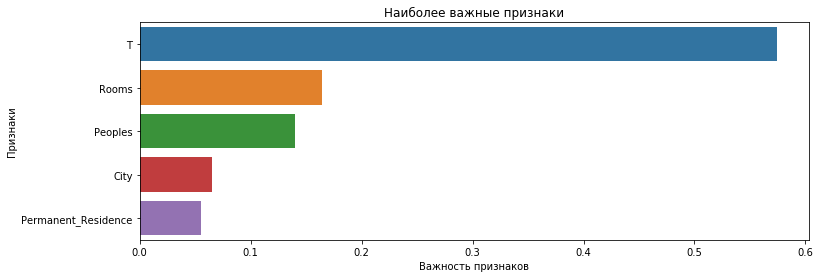

In [99]:
headers = list(X_train.columns.values)
feature_imp = pd.Series(model_rf.feature_importances_,index=headers).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title("Наиболее важные признаки")
plt.show()

Общий вывод при применении наиболее точных данных в модели: точность модели не улучшилась. 

Надо подобрать параметры модели и посмотреть на результат.

### Этап 7. Добавление 2-х новых признаков - потребление за 2019 год и последний месяц. Построение и оптимизация моделей

Для добавления признаков создаем датасет ds_sum, который является группировкой общего датасета ds_supply по потреблению за 2019 год, и датасет ds_month по последнему месяцу (март 2020 года).

In [100]:
ds_supply.head()

,Method,Consumer,Building,Supply,Period,T,Rooms,Peoples,Loss2019,Group
0,ЛС-СДСД,66700000233,дача,0.0,01-2019,-11.163823,1.0,1.0,0.027669,Население сельское
1,ЛС-СДСД,66700000410,дача,0.0,01-2019,-11.163823,1.0,1.0,0.027669,Население сельское
2,ЛС-СДСД,66700000431,част. ж/дом,2.0,01-2019,-11.163823,1.0,1.0,0.027669,Население сельское
3,ЛС-СДСД,66700000557,дача,2.0,01-2019,-11.163823,1.0,1.0,0.027669,Население сельское
4,ЛС-СДСД,66700000575,дача,21.0,01-2019,-11.163823,1.0,1.0,0.027669,Население сельское


In [101]:
ds_supply[ds_supply['Period'].str.contains('2019')]['Period'].unique()

array(['01-2019', '02-2019', '03-2019', '04-2019', '05-2019', '06-2019',
       '07-2019', '08-2019', '09-2019', '10-2019', '11-2019', '12-2019'],
      dtype=object)

In [102]:
ds_sum = ds_supply[ds_supply['Period'].str.contains('2019')].groupby('Consumer').agg({'Supply': 'sum'}).rename(columns={'Supply': '2019'}).reset_index()


In [103]:
ds_sum.head()

,Consumer,2019
0,000001,512.0
1,000002,9334.0
2,00003,846549.0
3,00006,180050.0
4,0130,37470.0


In [104]:
ds_month = ds_supply[ds_supply['Period'].str.contains('03-2020')].groupby('Consumer').agg({'Supply': 'sum'}).rename(columns={'Supply': 'LastMonth'}).reset_index()

In [105]:
ds_month.head()

,Consumer,LastMonth
0,000001,64.0
1,069101010004,0.0
2,069106057057,0.0
3,1113701304,168.0
4,1113701344,54.0


Заново создаем рабочий датасет ds_sdsd_2 с добавлением 2-х признаков - потребление за 2019 год и последний месяц. 

In [106]:
ds_supply.drop('Period', axis=1, inplace=True)
ds_supply['Permanent_Residence'] = ds_supply['Building'].apply(Permanent_Residence)
ds_supply.drop('Building', axis=1, inplace=True)
ds_supply['City'] = ds_supply['Group'].apply(City_Residence)
ds_supply.drop('Group', axis=1, inplace=True)
ds_supply = ds_supply[~ds_supply['Consumer'].str.contains('\D+',flags=re.IGNORECASE, regex=True)]

In [107]:
ds_supply.fillna(value={'Rooms': 2, 'Peoples': 2, 'Loss2019': 0.1395}, inplace=True)
ds_supply.isnull().sum()

Method                 0
Consumer               0
Supply                 0
T                      0
Rooms                  0
Peoples                0
Loss2019               0
Permanent_Residence    0
City                   0
dtype: int64

In [108]:
ds_supply.head()

,Method,Consumer,Supply,T,Rooms,Peoples,Loss2019,Permanent_Residence,City
0,ЛС-СДСД,66700000233,0.0,-11.163823,1.0,1.0,0.027669,0,0
1,ЛС-СДСД,66700000410,0.0,-11.163823,1.0,1.0,0.027669,0,0
2,ЛС-СДСД,66700000431,2.0,-11.163823,1.0,1.0,0.027669,1,0
3,ЛС-СДСД,66700000557,2.0,-11.163823,1.0,1.0,0.027669,0,0
4,ЛС-СДСД,66700000575,21.0,-11.163823,1.0,1.0,0.027669,0,0


Создаем копию основного датасета ds_supply под именем ds_sdsd_2

In [109]:
ds_sdsd_2 = ds_supply.copy()

In [110]:
ds_sdsd_2 = ds_sdsd_2[ds_sdsd_2['Method']=='ЛС-СДСД']

In [111]:
ds_sdsd_2 = ds_sdsd_2.merge(ds_sum, how = 'left', left_on='Consumer', right_on='Consumer')
ds_sdsd_2.head()

,Method,Consumer,Supply,T,Rooms,Peoples,Loss2019,Permanent_Residence,City,2019
0,ЛС-СДСД,66700000233,0.0,-11.163823,1.0,1.0,0.027669,0,0,174.0
1,ЛС-СДСД,66700000410,0.0,-11.163823,1.0,1.0,0.027669,0,0,6426.0
2,ЛС-СДСД,66700000431,2.0,-11.163823,1.0,1.0,0.027669,1,0,1978.0
3,ЛС-СДСД,66700000557,2.0,-11.163823,1.0,1.0,0.027669,0,0,766.0
4,ЛС-СДСД,66700000575,21.0,-11.163823,1.0,1.0,0.027669,0,0,903.0


In [112]:
ds_sdsd_2 = ds_sdsd_2.merge(ds_month, how = 'left', left_on='Consumer', right_on='Consumer')
ds_sdsd_2.head()

,Method,Consumer,Supply,T,Rooms,Peoples,Loss2019,Permanent_Residence,City,2019,LastMonth
0,ЛС-СДСД,66700000233,0.0,-11.163823,1.0,1.0,0.027669,0,0,174.0,0.0
1,ЛС-СДСД,66700000410,0.0,-11.163823,1.0,1.0,0.027669,0,0,6426.0,1343.0
2,ЛС-СДСД,66700000431,2.0,-11.163823,1.0,1.0,0.027669,1,0,1978.0,2.0
3,ЛС-СДСД,66700000557,2.0,-11.163823,1.0,1.0,0.027669,0,0,766.0,1.0
4,ЛС-СДСД,66700000575,21.0,-11.163823,1.0,1.0,0.027669,0,0,903.0,40.0


In [113]:
ds_sdsd_2.drop('Method', axis=1, inplace=True)
ds_sdsd_2.drop('Consumer', axis=1, inplace=True)
ds_sdsd_2.head()

,Supply,T,Rooms,Peoples,Loss2019,Permanent_Residence,City,2019,LastMonth
0,0.0,-11.163823,1.0,1.0,0.027669,0,0,174.0,0.0
1,0.0,-11.163823,1.0,1.0,0.027669,0,0,6426.0,1343.0
2,2.0,-11.163823,1.0,1.0,0.027669,1,0,1978.0,2.0
3,2.0,-11.163823,1.0,1.0,0.027669,0,0,766.0,1.0
4,21.0,-11.163823,1.0,1.0,0.027669,0,0,903.0,40.0


Удаляем столбец "Loss2019", он будет применен на следующем этапе для улучшения точности модели

In [114]:
ds_sdsd_2.drop('Loss2019', axis=1, inplace=True)
ds_sdsd_2.head()

,Supply,T,Rooms,Peoples,Permanent_Residence,City,2019,LastMonth
0,0.0,-11.163823,1.0,1.0,0,0,174.0,0.0
1,0.0,-11.163823,1.0,1.0,0,0,6426.0,1343.0
2,2.0,-11.163823,1.0,1.0,1,0,1978.0,2.0
3,2.0,-11.163823,1.0,1.0,0,0,766.0,1.0
4,21.0,-11.163823,1.0,1.0,0,0,903.0,40.0


Датасет ds_sdsd_2 сформирован, устраняем снова выбросы

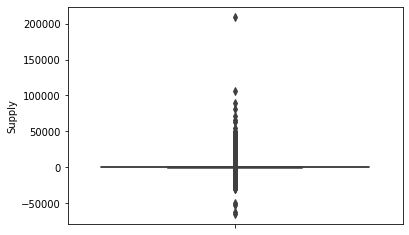

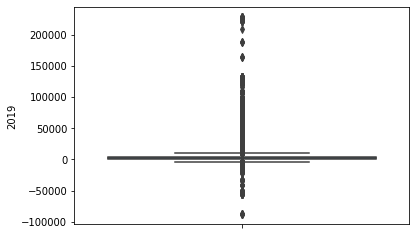

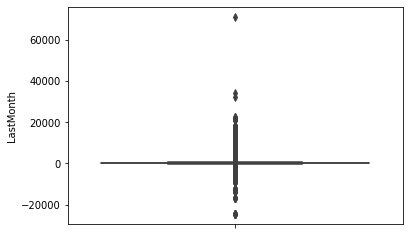

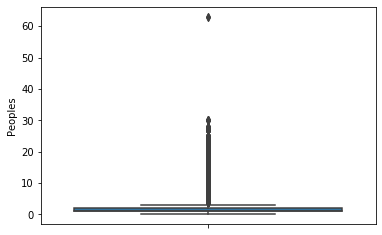

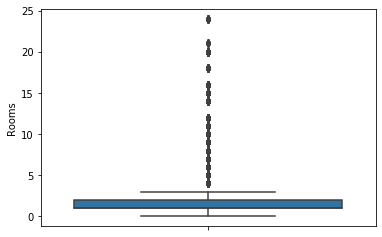

In [115]:
sns.boxplot(y="Supply", data=ds_sdsd_2)
plt.show()
sns.boxplot(y="2019", data=ds_sdsd_2)
plt.show()
sns.boxplot(y="LastMonth", data=ds_sdsd_2)
plt.show()
sns.boxplot(y="Peoples", data=ds_sdsd_2)
plt.show()
sns.boxplot(y="Rooms", data=ds_sdsd_2)
plt.show()

In [116]:
ds_sdsd_2 = ds_sdsd_2[ds_sdsd_2['Supply'] >=1]
ds_sdsd_2 = ds_sdsd_2[ds_sdsd_2['2019'] >=1]
ds_sdsd_2 = ds_sdsd_2[ds_sdsd_2['LastMonth'] >=1]
ds_sdsd_2 = ds_sdsd_2[ds_sdsd_2['Supply'] <4000]
ds_sdsd_2 = ds_sdsd_2[ds_sdsd_2['2019'] <50000]
ds_sdsd_2 = ds_sdsd_2[ds_sdsd_2['LastMonth'] <4000]
ds_sdsd_2 = ds_sdsd_2[ds_sdsd_2['Peoples'] <10]
ds_sdsd_2 = ds_sdsd_2[ds_sdsd_2['Rooms'] <10]

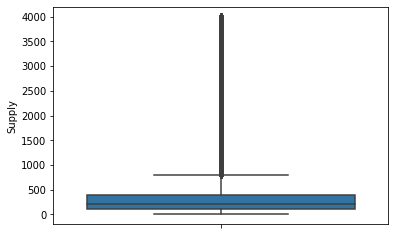

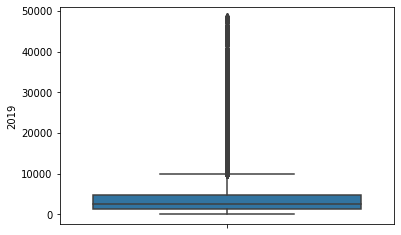

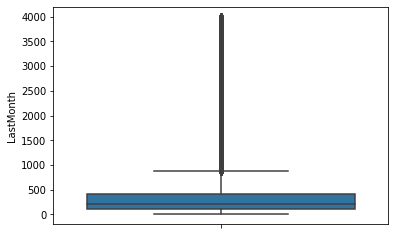

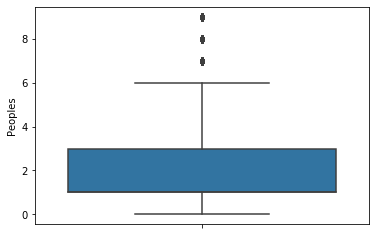

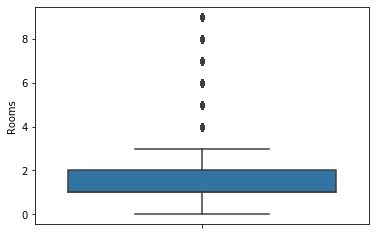

In [117]:
sns.boxplot(y="Supply", data=ds_sdsd_2)
plt.show()
sns.boxplot(y="2019", data=ds_sdsd_2)
plt.show()
sns.boxplot(y="LastMonth", data=ds_sdsd_2)
plt.show()
sns.boxplot(y="Peoples", data=ds_sdsd_2)
plt.show()
sns.boxplot(y="Rooms", data=ds_sdsd_2)
plt.show()

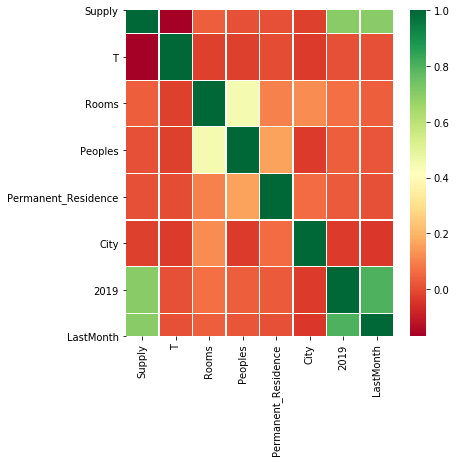

In [118]:
f, ax = plt.subplots(figsize=(6, 6))
corr = np.round_(ds_sdsd_2.corr(), decimals=2)
sns.heatmap(corr,annot=False,cmap='RdYlGn',linewidths=0.2)

Линейная регрессия

In [119]:
X_train, X_test, y_train, y_test = train_test_split(ds_sdsd_2[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City','2019','LastMonth']], ds_sdsd_2['Supply'], test_size=0.3)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [120]:
r_train = model.score(X_train, y_train)
r_test = model.score(X_test, y_test)
print('Качество модели на тестовых данных:', r_test, '\nКачество модели на тренировочных данных:', r_train)
model_pred = model.predict(X_test)
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, model_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, model_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, model_pred)))
mape = np.mean(np.abs((y_test - model_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Model score:', model.score(X_test, y_test))
print('R2 score:', r2_score(y_test, model_pred))

Качество модели на тестовых данных: 0.5805375471773521 
Качество модели на тренировочных данных: 0.5822145896792679
Mean Absolute Error (MAE): 173.7967112338439
Mean Squared Error (MSE): 102877.21635249541
Root Mean Squared Error (RMSE): 320.74478382741535
Mean Absolute Percentage Error (MAPE): 467.78
Model score: 0.5805375471773521
R2 score: 0.5805375471773521


In [121]:
sum_pred = sum(model_pred)
sum_fact = sum(y_test)
print('Прогноз потребления населением на тестовом наборе данных: ',round(sum_pred,0),'кВт*ч')
print('Фактическое потребления населением на тестовом наборе данных: ',round(sum_fact,0),'кВт*ч')
print('Разница между фактом и прогнозом, абсолют:',round(sum_fact - sum_pred,0),'кВт*ч', 
      ' процент:', round(100*np.abs((sum_fact - sum_pred))/sum_pred,4),'%')

Прогноз потребления населением на тестовом наборе данных:  67284181.0 кВт*ч
Фактическое потребления населением на тестовом наборе данных:  67542386.0 кВт*ч
Разница между фактом и прогнозом, абсолют: 258205.0 кВт*ч  процент: 0.3838 %


Случайный лес

In [122]:
X_train, X_test, y_train, y_test = train_test_split(ds_sdsd_2[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City','2019','LastMonth']], ds_sdsd_2['Supply'], test_size=0.3)
model_rf=RandomForestRegressor(n_estimators=100, max_features='auto', n_jobs=4, random_state=1)
model_rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=4, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [123]:
model_pred = model_rf.predict(X_test)
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, model_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, model_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, model_pred)))
mape = np.mean(np.abs((y_test - model_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Model score:', model_rf.score(X_test, y_test))
print('R2 score:', r2_score(y_test, model_pred))

Mean Absolute Error (MAE): 106.44879836418555
Mean Squared Error (MSE): 60495.16715911842
Root Mean Squared Error (RMSE): 245.95765318265342
Mean Absolute Percentage Error (MAPE): 181.27
Model score: 0.7505675258325037
R2 score: 0.7505675258325037


In [124]:
sum_pred = sum(model_pred)
sum_fact = sum(y_test)
print('Прогноз потребления населением на тестовом наборе данных: ',round(sum_pred,0),'кВт*ч')
print('Фактическое потребления населением на тестовом наборе данных: ',round(sum_fact,0),'кВт*ч')
print('Разница между фактом и прогнозом, абсолют:',round(sum_fact - sum_pred,0),'кВт*ч', 
      ' процент:', round(100*np.abs((sum_fact - sum_pred))/sum_pred,4),'%')

Прогноз потребления населением на тестовом наборе данных:  67858685.0 кВт*ч
Фактическое потребления населением на тестовом наборе данных:  67259847.0 кВт*ч
Разница между фактом и прогнозом, абсолют: -598838.0 кВт*ч  процент: 0.8825 %


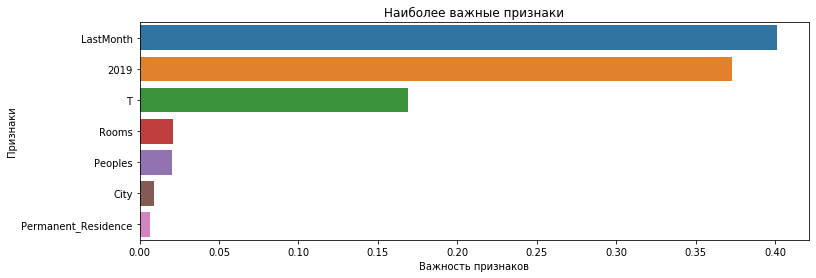

In [125]:
headers = list(X_train.columns.values)
feature_imp = pd.Series(model_rf.feature_importances_,index=headers).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title("Наиболее важные признаки")
plt.show()

### Этап 8. Градиентный бустинг (GradientBoostingRegressor)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(ds_sdsd_2[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City','2019','LastMonth']], ds_sdsd_2['Supply'], test_size=0.3)
model_gbr = GradientBoostingRegressor()
model_gbr.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [127]:
model_pred = model_gbr.predict(X_test)
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, model_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, model_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, model_pred)))
mape = np.mean(np.abs((y_test - model_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Model score:', model_gbr.score(X_test, y_test))
print('R2 score:', r2_score(y_test, model_pred))

Mean Absolute Error (MAE): 120.82973148456058
Mean Squared Error (MSE): 68533.31201254645
Root Mean Squared Error (RMSE): 261.788678159592
Mean Absolute Percentage Error (MAPE): 262.36
Model score: 0.7184459423142469
R2 score: 0.7184459423142469


In [128]:
sum_pred = sum(model_pred)
sum_fact = sum(y_test)
print('Прогноз потребления населением на тестовом наборе данных: ',round(sum_pred,0),'кВт*ч')
print('Фактическое потребления населением на тестовом наборе данных: ',round(sum_fact,0),'кВт*ч')
print('Разница между фактом и прогнозом, абсолют:',round(sum_fact - sum_pred,0),'кВт*ч', 
      ' процент:', round(100*np.abs((sum_fact - sum_pred))/sum_pred,4),'%')

Прогноз потребления населением на тестовом наборе данных:  67207725.0 кВт*ч
Фактическое потребления населением на тестовом наборе данных:  67172966.0 кВт*ч
Разница между фактом и прогнозом, абсолют: -34759.0 кВт*ч  процент: 0.0517 %


Вывод: Пока результаты модели чуть похуже, чем у Случайного леса.

### Этап 9. Добавление нового признака - потери электроэнергии за 2019 год, применение 3-х моделей, сравнение результатов

9.1. Создаем новый датасет ds_sdsd_3 из основного датасета ds_supply, делаем снова очистку данных и т.д.

In [129]:
ds_sdsd_3 = ds_supply.copy()
ds_sdsd_3 = ds_sdsd_3[ds_sdsd_3['Method']=='ЛС-СДСД']
ds_sdsd_3 = ds_sdsd_3.merge(ds_sum, how = 'left', left_on='Consumer', right_on='Consumer')
ds_sdsd_3 = ds_sdsd_3.merge(ds_month, how = 'left', left_on='Consumer', right_on='Consumer')
ds_sdsd_3.drop('Method', axis=1, inplace=True)
ds_sdsd_3.drop('Consumer', axis=1, inplace=True)
ds_sdsd_3.head()

,Supply,T,Rooms,Peoples,Loss2019,Permanent_Residence,City,2019,LastMonth
0,0.0,-11.163823,1.0,1.0,0.027669,0,0,174.0,0.0
1,0.0,-11.163823,1.0,1.0,0.027669,0,0,6426.0,1343.0
2,2.0,-11.163823,1.0,1.0,0.027669,1,0,1978.0,2.0
3,2.0,-11.163823,1.0,1.0,0.027669,0,0,766.0,1.0
4,21.0,-11.163823,1.0,1.0,0.027669,0,0,903.0,40.0


In [130]:
ds_sdsd_3 = ds_sdsd_3[ds_sdsd_3['Supply'] >=1]
ds_sdsd_3 = ds_sdsd_3[ds_sdsd_3['2019'] >=1]
ds_sdsd_3 = ds_sdsd_3[ds_sdsd_3['LastMonth'] >=1]
ds_sdsd_3 = ds_sdsd_3[ds_sdsd_3['Supply'] <4000]
ds_sdsd_3 = ds_sdsd_3[ds_sdsd_3['2019'] <50000]
ds_sdsd_3 = ds_sdsd_3[ds_sdsd_3['LastMonth'] <4000]
ds_sdsd_3 = ds_sdsd_3[ds_sdsd_3['Peoples'] <10]
ds_sdsd_3 = ds_sdsd_3[ds_sdsd_3['Rooms'] <10]

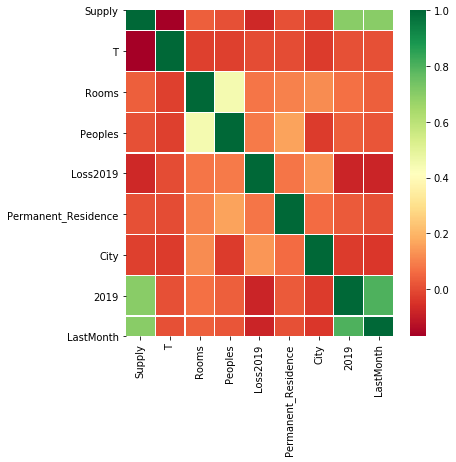

In [131]:
f, ax = plt.subplots(figsize=(6, 6))
corr = np.round_(ds_sdsd_3.corr(), decimals=2)
sns.heatmap(corr,annot=False,cmap='RdYlGn',linewidths=0.2)

9.2. Линейная регрессия

In [132]:
X_train, X_test, y_train, y_test = train_test_split(ds_sdsd_3[['T', 'Rooms', 'Peoples', 'Loss2019', 'Permanent_Residence','City','2019','LastMonth']], ds_sdsd_3['Supply'], test_size=0.3)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [133]:
r_train = model.score(X_train, y_train)
r_test = model.score(X_test, y_test)
print('Качество модели на тестовых данных:', r_test, '\nКачество модели на тренировочных данных:', r_train)
model_pred = model.predict(X_test)
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, model_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, model_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, model_pred)))
mape = np.mean(np.abs((y_test - model_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Model score:', model.score(X_test, y_test))
print('R2 score:', r2_score(y_test, model_pred))

Качество модели на тестовых данных: 0.5777674497360669 
Качество модели на тренировочных данных: 0.583477375626288
Mean Absolute Error (MAE): 173.9612301181976
Mean Squared Error (MSE): 103061.49675767668
Root Mean Squared Error (RMSE): 321.0319248262962
Mean Absolute Percentage Error (MAPE): 475.71
Model score: 0.5777674497360669
R2 score: 0.5777674497360669


In [134]:
sum_pred = sum(model_pred)
sum_fact = sum(y_test)
print('Прогноз потребления населением на тестовом наборе данных: ',round(sum_pred,0),'кВт*ч')
print('Фактическое потребления населением на тестовом наборе данных: ',round(sum_fact,0),'кВт*ч')
print('Разница между фактом и прогнозом, абсолют:',round(sum_fact - sum_pred,0),'кВт*ч', 
      ' процент:', round(100*np.abs((sum_fact - sum_pred))/sum_pred,4),'%')

Прогноз потребления населением на тестовом наборе данных:  67580560.0 кВт*ч
Фактическое потребления населением на тестовом наборе данных:  67474151.0 кВт*ч
Разница между фактом и прогнозом, абсолют: -106409.0 кВт*ч  процент: 0.1575 %


9.3. Случайный лес

In [135]:
X_train, X_test, y_train, y_test = train_test_split(ds_sdsd_3[['T', 'Rooms', 'Peoples', 'Loss2019', 'Permanent_Residence','City','2019','LastMonth']], ds_sdsd_3['Supply'], test_size=0.3)
model_rf=RandomForestRegressor(n_estimators=100, max_features='auto', n_jobs=4, random_state=1)
model_rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=4, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [136]:
model_pred = model_rf.predict(X_test)
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, model_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, model_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, model_pred)))
mape = np.mean(np.abs((y_test - model_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Model score:', model_rf.score(X_test, y_test))
print('R2 score:', r2_score(y_test, model_pred))

Mean Absolute Error (MAE): 104.06557217649559
Mean Squared Error (MSE): 58699.296354820195
Root Mean Squared Error (RMSE): 242.27937666012804
Mean Absolute Percentage Error (MAPE): 173.83
Model score: 0.7584918468772976
R2 score: 0.7584918468772976


In [137]:
sum_pred = sum(model_pred)
sum_fact = sum(y_test)
print('Прогноз потребления населением на тестовом наборе данных: ',round(sum_pred,0),'кВт*ч')
print('Фактическое потребления населением на тестовом наборе данных: ',round(sum_fact,0),'кВт*ч')
print('Разница между фактом и прогнозом, абсолют:',round(sum_fact - sum_pred,0),'кВт*ч', 
      ' процент:', round(100*np.abs((sum_fact - sum_pred))/sum_pred,4),'%')

Прогноз потребления населением на тестовом наборе данных:  68056727.0 кВт*ч
Фактическое потребления населением на тестовом наборе данных:  67453058.0 кВт*ч
Разница между фактом и прогнозом, абсолют: -603669.0 кВт*ч  процент: 0.887 %


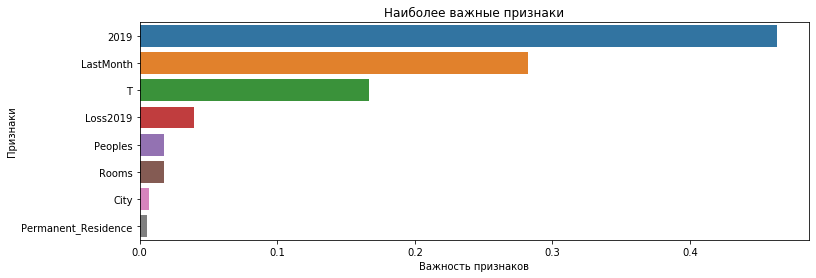

In [138]:
headers = list(X_train.columns.values)
feature_imp = pd.Series(model_rf.feature_importances_,index=headers).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title("Наиболее важные признаки")
plt.show()

9.4. Градиентный бустинг

In [139]:
X_train, X_test, y_train, y_test = train_test_split(ds_sdsd_3[['T', 'Rooms', 'Peoples', 'Loss2019', 'Permanent_Residence','City','2019','LastMonth']], ds_sdsd_3['Supply'], test_size=0.3)
model_gbr = GradientBoostingRegressor()
model_gbr.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [140]:
model_pred = model_gbr.predict(X_test)
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, model_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, model_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, model_pred)))
mape = np.mean(np.abs((y_test - model_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Model score:', model_gbr.score(X_test, y_test))
print('R2 score:', r2_score(y_test, model_pred))

Mean Absolute Error (MAE): 121.07994357794159
Mean Squared Error (MSE): 68169.91021588935
Root Mean Squared Error (RMSE): 261.0936809191087
Mean Absolute Percentage Error (MAPE): 257.28
Model score: 0.7202775785653951
R2 score: 0.7202775785653951


In [141]:
sum_pred = sum(model_pred)
sum_fact = sum(y_test)
print('Прогноз потребления населением на тестовом наборе данных: ',round(sum_pred,0),'кВт*ч')
print('Фактическое потребления населением на тестовом наборе данных: ',round(sum_fact,0),'кВт*ч')
print('Разница между фактом и прогнозом, абсолют:',round(sum_fact - sum_pred,0),'кВт*ч', 
      ' процент:', round(100*np.abs((sum_fact - sum_pred))/sum_pred,4),'%')

Прогноз потребления населением на тестовом наборе данных:  67468435.0 кВт*ч
Фактическое потребления населением на тестовом наборе данных:  67347261.0 кВт*ч
Разница между фактом и прогнозом, абсолют: -121174.0 кВт*ч  процент: 0.1796 %


### Этап 10. Гиперпараметрическая оптимизация модели градиентного бустинга. Случайный поиск с перекрёстной проверкой

Устанавливаем параметры

In [142]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']
# Number of trees used in the boosting process
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 50)]
# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 20]
# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 8]
# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10, 20]
# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]
# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'max_features': max_features}

Получаем наилучшие параметры модели

In [143]:
%%time
# Create the model to use for hyperparameter tuning
model_gbr_cv = GradientBoostingRegressor(random_state = 42)
# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model_gbr_cv,
    param_distributions=hyperparameter_grid,
    cv=4, n_iter=50, 
    scoring = 'neg_mean_absolute_error',
    n_jobs = 4, verbose = 1, 
    return_train_score = True,
    random_state=42)
# Fit on the training data
random_cv.fit(X_train,y_train) 
# Find the best combination of settings
random_cv.best_estimator_

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 117.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 370.9min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed: 373.4min finished


Wall time: 6h 21min 25s


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=10, max_features='log2',
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=2,
                          min_samples_split=4, min_weight_fraction_leaf=0.0,
                          n_estimators=440, n_iter_no_change=None,
                          presort='deprecated', random_state=42, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

Наилучшие параметры на заданных интервалах:
- loss='huber'
- n_estimators=440
- max_depth=10
- min_samples_leaf=2
- min_samples_split=4
- max_features='log2'

Проверяем результат на наилучших параметрах и базовой модели

In [144]:
def evaluate(model, test_features, test_labels):
    model_pred = model.predict(test_features)
    print('Model Performance')
    mae = mean_absolute_error(test_labels, model_pred)
    print('Mean Absolute Error (MAE):', mae)
    print('Mean Squared Error (MSE):', mean_squared_error(test_labels, model_pred))
    print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(test_labels, model_pred)))
    mape = np.mean(np.abs((test_labels - model_pred) / np.abs(test_labels)))
    print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
    print('Model score:', model.score(test_features, test_labels))
    
    sum_pred = sum(model_pred)
    sum_fact = sum(test_labels)
    print('Прогноз потребления населением на тестовом наборе данных: ',round(sum_pred,0),'кВт*ч')
    print('Фактическое потребления населением на тестовом наборе данных: ',round(sum_fact,0),'кВт*ч')
    print('Разница между фактом и прогнозом, абсолют:',round(sum_fact - sum_pred,0),'кВт*ч', 
          ' процент:', round(100*np.abs((sum_fact - sum_pred))/sum_pred,4),'%')
    
    return mae

In [145]:
base_model = GradientBoostingRegressor(n_estimators = 100, random_state = 42)
base_model.fit(X_train,y_train)
base_mae = evaluate(base_model, X_test, y_test)

best_random = random_cv.best_estimator_
best_random_mae = evaluate(best_random, X_test, y_test)

print('Улучшение на {:0.2f}%.'.format(100 * (-1) * (best_random_mae - base_mae) / base_mae))

Model Performance
Mean Absolute Error (MAE): 121.07994357794158
Mean Squared Error (MSE): 68169.91021588938
Root Mean Squared Error (RMSE): 261.09368091910875
Mean Absolute Percentage Error (MAPE): 257.28
Model score: 0.720277578565395
Прогноз потребления населением на тестовом наборе данных:  67468435.0 кВт*ч
Фактическое потребления населением на тестовом наборе данных:  67347261.0 кВт*ч
Разница между фактом и прогнозом, абсолют: -121174.0 кВт*ч  процент: 0.1796 %
Model Performance
Mean Absolute Error (MAE): 97.68145684003775
Mean Squared Error (MSE): 54942.78716281704
Root Mean Squared Error (RMSE): 234.39877807449645
Mean Absolute Percentage Error (MAPE): 157.73
Model score: 0.7745525934114097
Прогноз потребления населением на тестовом наборе данных:  65299877.0 кВт*ч
Фактическое потребления населением на тестовом наборе данных:  67347261.0 кВт*ч
Разница между фактом и прогнозом, абсолют: 2047384.0 кВт*ч  процент: 3.1354 %
Улучшение на 19.32%.
